# JPX Tokyo Stock Exchange Original Notebook

In this [Kaggle competition](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview) 

>Japan Exchange Group, Inc. (JPX) is a holding company operating one of the largest stock exchanges in the world, Tokyo Stock Exchange (TSE), and derivatives exchanges Osaka Exchange (OSE) and Tokyo Commodity Exchange (TOCOM). JPX is hosting this competition and is supported by AI technology company AlpacaJapan Co.,Ltd.

> In this competition, you will model real future returns of around 2,000 stocks. The competition will involve building portfolios from the stocks eligible for predictions. The stocks are ranked from highest to lowest expected returns and they are evaluated on the difference in returns between the top and bottom 200 stocks.

In [1]:
!pip install -r requirements.txt --user --quiet

# Imports

In this section we import the packages we need for this example. Make it a habit to gather your imports in a single place.

In [2]:
import sys, os
from tqdm import tqdm
import subprocess
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import zipfile
import joblib
import gc

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

pd.set_option('display.max_columns', 500)
sys.path.insert(0, 'helper-files')
from local_api import local_api

# Project hyper-parameters

In [3]:
# Hyper-parameters
LR = 0.379687157316759
N_EST = 100

Set random seed for reproducibility and ignore warning messages.

In [4]:
np.random.seed(42)

# Download and load the dataset

In this section, we download the data from kaggle to get it in a ready-to-use form by the model. 

First, let us load and analyze the data.

The data are in csv format, thus, we use the handy read_csv pandas method. There is one train data set and two test sets (one public and one private).

In [5]:
# setup kaggle environment for data download
dataset = "jpx-tokyo-stock-exchange-prediction"

# setup kaggle environment for data download
with open('/secret/kaggle-secret/password', 'r') as file:
    kaggle_key = file.read().rstrip()
with open('/secret/kaggle-secret/username', 'r') as file:
    kaggle_user = file.read().rstrip()

os.environ['KAGGLE_USERNAME'], os.environ['KAGGLE_KEY'] = kaggle_user, kaggle_key

# download kaggle's jpx-tokyo-stock-exchange-prediction data
subprocess.run(["kaggle","competitions", "download", "-c", dataset])

CompletedProcess(args=['kaggle', 'competitions', 'download', '-c', 'jpx-tokyo-stock-exchange-prediction'], returncode=0)

In [6]:
# path to download to
data_path = os.getcwd()

# extract jpx-tokyo-stock-exchange-prediction.zip to load_data_path
with zipfile.ZipFile(f"{dataset}.zip","r") as zip_ref:
    zip_ref.extractall(data_path)

In [7]:
# read train_files/stock_prices.csv
df_prices = pd.read_csv(f"{data_path}/train_files/stock_prices.csv", parse_dates=['Date'])

In [8]:
df_prices['Date'].max()

Timestamp('2021-12-03 00:00:00')

In [9]:
df_prices.tail(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098
2332530,20211203_9997,2021-12-03,9997,690.0,711.0,686.0,696.0,381100,1.0,NaN,False,0.018414


In [10]:
# lets check data dimensions
df_prices.shape

(2332531, 12)

In [11]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   RowId             object        
 1   Date              datetime64[ns]
 2   SecuritiesCode    int64         
 3   Open              float64       
 4   High              float64       
 5   Low               float64       
 6   Close             float64       
 7   Volume            int64         
 8   AdjustmentFactor  float64       
 9   ExpectedDividend  float64       
 10  SupervisionFlag   bool          
 11  Target            float64       
dtypes: bool(1), datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 198.0+ MB


In [12]:
# check total nan values per column
df_prices.isna().sum()

RowId                     0
Date                      0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

# Transform Data

In [13]:
# sort data by 'Date' and 'SecuritiesCode'
df_prices.sort_values(by=['Date','SecuritiesCode'], inplace=True)

In [14]:
# sort data by 'Date' and 'SecuritiesCode'
df_prices.sort_values(by=['Date','SecuritiesCode'], inplace=True)

In [15]:
# count total trading stocks per day 
idcount = df_prices.groupby("Date")["SecuritiesCode"].count().reset_index()
idcount

,Date,SecuritiesCode
0,2017-01-04,1865
1,2017-01-05,1865
2,2017-01-06,1865
3,2017-01-10,1865
4,2017-01-11,1865
...,...,...
1197,2021-11-29,2000
1198,2021-11-30,2000
1199,2021-12-01,2000
1200,2021-12-02,2000


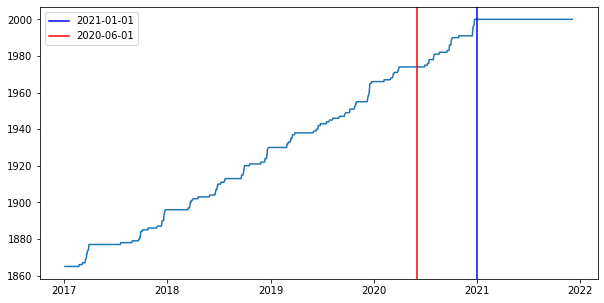

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(idcount["Date"],idcount["SecuritiesCode"])
plt.axvline(x=['2021-01-01'], color='blue', label='2021-01-01')
plt.axvline(x=['2020-06-01'], color='red', label='2020-06-01')
plt.legend()
plt.show()

In [17]:
idcount[idcount['SecuritiesCode'] >= 2000]

,Date,SecuritiesCode
970,2020-12-23,2000
971,2020-12-24,2000
972,2020-12-25,2000
973,2020-12-28,2000
974,2020-12-29,2000
...,...,...
1197,2021-11-29,2000
1198,2021-11-30,2000
1199,2021-12-01,2000
1200,2021-12-02,2000


In [18]:
idcount[idcount['SecuritiesCode'] >= 2000]['SecuritiesCode'].sum()

464000

In [19]:
# filter out data with less than 2000 stock counts in a day
# dates before ‘2020-12-23’ all have stock counts less than 2000
# This is done to work with consistent data 
df_prices = df_prices[(df_prices["Date"]>="2020-12-23")]

In [20]:
df_prices = df_prices.reset_index(drop=True)

In [21]:
df_prices.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20201223_1301,2020-12-23,1301,2913.0,2920.0,2906.0,2913.0,6300,1.0,NaN,False,-0.000343
1,20201223_1332,2020-12-23,1332,419.0,421.0,416.0,419.0,1413600,1.0,NaN,False,0.007143
2,20201223_1333,2020-12-23,1333,2187.0,2195.0,2158.0,2165.0,119000,1.0,NaN,False,0.005051
3,20201223_1375,2020-12-23,1375,1711.0,1757.0,1701.0,1752.0,446300,1.0,NaN,False,-0.003484
4,20201223_1376,2020-12-23,1376,1589.0,1589.0,1575.0,1586.0,1900,1.0,NaN,False,-0.009494


In [22]:
df_prices.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target'],
      dtype='object')

In [23]:
#calculate z-scores of `df`
z_scores = stats.zscore(df_prices[['Open', 'High', 'Low', 'Close','Volume']], nan_policy='omit')
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_zscore = df_prices[filtered_entries]
df_zscore = df_zscore.reset_index(drop=True)

In [24]:
df_zscore = df_zscore.reset_index(drop=True)

<h1>Feature Engineering
    

In [25]:
def feat_eng(df, features):

    for i in tqdm(range(1, 4)):
        # creating lag features
        tmp = df[features].shift(i)
        tmp.columns = [c + f'_next_shift_{i}' for c in tmp.columns]
        df = pd.concat([df, tmp], sort=False, axis=1)

    for i in tqdm(range(1, 4)):
        df[f'weighted_vol_price_{i}'] = np.log(df[f'Volume_next_shift_{i}'] * df[[col for col in df if col.endswith(f'next_shift_{i}')][:-1]].apply(np.mean, axis=1))
       
    # feature engineering
    df['weighted_vol_price'] = np.log(df['Volume'] * (np.mean(df[features[:-1]], axis=1)))
    df['BOP'] = (df['Open']-df['Close'])/(df['High']-df['Low'])
    df['HL'] = df['High'] - df['Low']
    df['OC'] = df['Close'] - df['Open']
    df['OHLCstd'] = df[['Open','Close','High','Low']].std(axis=1)
    
    feats = df.select_dtypes(include=float).columns
    df[feats] = df[feats].apply(np.log)
    
    # replace inf with nan
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # datetime features
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day'] = df['Date'].dt.weekday.astype(np.int32)
    df["dayofyear"] = df['Date'].dt.dayofyear
    df["is_weekend"] = df['Day'].isin([5, 6])
    df["weekofyear"] = df['Date'].dt.weekofyear
    df["month"] = df['Date'].dt.month
    df["season"] = (df["month"]%12 + 3)//3
    
    # fill nan values
    df = df.fillna(0)
    return df

In [26]:
new_feats = feat_eng(df_zscore, ['High', 'Low', 'Open', 'Close', 'Volume'])

100%|██████████| 3/3 [04:10<00:00, 83.49s/it]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [27]:
new_feats.shape

(452481, 41)

In [28]:
new_feats['Target'] = df_zscore['Target']

In [29]:
new_feats.head(7)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,High_next_shift_1,Low_next_shift_1,Open_next_shift_1,Close_next_shift_1,Volume_next_shift_1,High_next_shift_2,Low_next_shift_2,Open_next_shift_2,Close_next_shift_2,Volume_next_shift_2,High_next_shift_3,Low_next_shift_3,Open_next_shift_3,Close_next_shift_3,Volume_next_shift_3,weighted_vol_price_1,weighted_vol_price_2,weighted_vol_price_3,weighted_vol_price,BOP,HL,OC,OHLCstd,Day,dayofyear,is_weekend,weekofyear,month,season
0,20201223_1301,2020-12-23,1301,7.976939,7.979339,7.974533,7.976939,6300,0.0,0.0,False,-0.000343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.816919,0.000000,2.639057,0.000000,1.743178,2,358,False,52,12,1
1,20201223_1332,2020-12-23,1332,6.037871,6.042633,6.030685,6.037871,1413600,0.0,0.0,False,0.007143,7.979339,7.974533,7.976939,7.976939,8.748305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.816919,0.000000,0.000000,3.005629,0.000000,1.609438,0.000000,0.723459,2,358,False,52,12,1
2,20201223_1333,2020-12-23,1333,7.690286,7.693937,7.676937,7.680176,119000,0.0,0.0,False,0.005051,6.042633,6.030685,6.037871,6.037871,14.161650,7.979339,7.974533,7.976939,7.976939,8.748305,0.000000,0.000000,0.000000,0.000000,0.000000,3.005629,2.816919,0.000000,2.963841,-0.519875,3.610918,0.000000,2.866536,2,358,False,52,12,1
3,20201223_1375,2020-12-23,1375,7.444833,7.471363,7.438972,7.468513,446300,0.0,0.0,False,-0.003484,7.693937,7.676937,7.690286,7.680176,11.686879,6.042633,6.030685,6.037871,6.037871,14.161650,7.979339,7.974533,7.976939,7.976939,8.748305,2.963841,3.005629,2.816919,3.018705,0.000000,4.025352,3.713572,3.345369,2,358,False,52,12,1
4,20201223_1376,2020-12-23,1376,7.370860,7.370860,7.362011,7.368970,1900,0.0,0.0,False,-0.009494,7.471363,7.438972,7.444833,7.468513,13.008747,7.693937,7.676937,7.690286,7.680176,11.686879,6.042633,6.030685,6.037871,6.037871,14.161650,3.018705,2.963841,3.005629,2.702555,-1.540445,2.639057,0.000000,1.894928,2,358,False,52,12,1
5,20201223_1377,2020-12-23,1377,8.167636,8.173293,8.160518,8.167636,62700,0.0,0.0,False,0.011252,7.370860,7.362011,7.370860,7.368970,7.549609,7.471363,7.438972,7.444833,7.468513,13.008747,7.693937,7.676937,7.690286,7.680176,11.686879,2.702555,3.018705,2.963841,2.955608,0.000000,3.806662,0.000000,2.913860,2,358,False,52,12,1
6,20201223_1379,2020-12-23,1379,7.652546,7.656337,7.647786,7.653969,29900,0.0,0.0,False,0.002373,8.173293,8.160518,8.167636,8.167636,11.046117,7.370860,7.362011,7.370860,7.368970,7.549609,7.471363,7.438972,7.444833,7.468513,13.008747,2.955608,2.702555,3.018705,2.888051,0.000000,2.890372,1.098612,2.026617,2,358,False,52,12,1


In [30]:
new_feats.columns

Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target', 'High_next_shift_1', 'Low_next_shift_1', 'Open_next_shift_1',
       'Close_next_shift_1', 'Volume_next_shift_1', 'High_next_shift_2',
       'Low_next_shift_2', 'Open_next_shift_2', 'Close_next_shift_2',
       'Volume_next_shift_2', 'High_next_shift_3', 'Low_next_shift_3',
       'Open_next_shift_3', 'Close_next_shift_3', 'Volume_next_shift_3',
       'weighted_vol_price_1', 'weighted_vol_price_2', 'weighted_vol_price_3',
       'weighted_vol_price', 'BOP', 'HL', 'OC', 'OHLCstd', 'Day', 'dayofyear',
       'is_weekend', 'weekofyear', 'month', 'season'],
      dtype='object')

# Modelling

In [31]:
# columns to be used for modelling.
feats = ['Date','SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume',
         'weighted_vol_price_1', 'weighted_vol_price_2', 'weighted_vol_price_3', 
       'weighted_vol_price', 'BOP', 'HL', 'OC', 'OHLCstd', 'Day', 'dayofyear',
       'is_weekend', 'weekofyear', 'month', 'season']

In [32]:
# transform date to int
new_feats['Date'] = new_feats['Date'].dt.strftime("%Y%m%d").astype(int)

# split data into valid for validation and train for model training
valid = new_feats[(new_feats['Date'] >= 20211111)].copy()
train = new_feats[(new_feats['Date'] < 20211111)].copy()

In [33]:
train.shape, valid.shape

((421376, 41), (31105, 41))

In [34]:
# model parameter
params = {
  'n_estimators': N_EST,
  'learning_rate': LR,
    'random_state': 42,
  'verbose' : 2}

# model initialization
model = LGBMRegressor(**params)


X = train[feats]
y = train["Target"]

X_test = valid[feats]
y_test = valid["Target"]

# fitting
model.fit(X, y, verbose=False, eval_set=(X_test, y_test))

/home/jovyan/.local/lib/python3.6/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.015059
[LightGBM] [Debug] init for col-wise cost 0.006485 seconds, init for row-wise cost 0.057868 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3981
[LightGBM] [Info] Number of data points in the train set: 421376, number of used features: 20
[LightGBM] [Info] Start training from score 0.000716
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug

LGBMRegressor(learning_rate=0.379687157316759, random_state=42, verbose=2)

<h1> Evaluation and Prediction

In [35]:
# model prediction
preds = model.predict(X_test)

# model evaluation
rmse = np.round(mean_squared_error(preds, y_test)**0.5, 5)

In [36]:
print(rmse)

0.02674


# Make submission

In [ ]:
myapi = local_api('supplemental_files')
env = myapi.make_env()

iter_test = env.iter_test()
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    prices = feat_eng(prices, ['High', 'Low', 'Open', 'Close', 'Volume'])
    prices['Date'] = prices['Date'].dt.strftime("%Y%m%d").astype(int)
    prices["Target"] = model.predict(prices[feats])
    if prices["Volume"].min()==0:
        sample_prediction["Prediction"] = 0
    else:
        sample_prediction["Prediction"] = prices["Target"]/prices["Volume"]
    sample_prediction["Prediction"] = prices["Target"]
    sample_prediction.sort_values(by="Prediction", ascending=False, inplace=True)
    sample_prediction['Rank'] = np.arange(0,2000)
    sample_prediction.sort_values(by = "SecuritiesCode", ascending=True, inplace=True)
    submission = sample_prediction[["Date","SecuritiesCode","Rank"]]
    env.predict(submission)
print(env.score())
submission.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 3/3 [00:01<00:00,  2.30it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
 67%|██████▋   | 2/3 [00:01<00:00,  1.02it/s]